In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_hourly_weather.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,Tavg,RH_avg,RR,ss
READ_DATE,,,,,
2019-01-01 00:00:00,2.402650,25.7,96.0,12.9,7.5
2019-01-01 01:00:00,2.408348,25.7,96.0,12.9,7.5
2019-01-01 02:00:00,2.406840,25.7,96.0,12.9,7.5
2019-01-01 03:00:00,2.256511,25.7,96.0,12.9,7.5
2019-01-01 04:00:00,2.065598,25.7,96.0,12.9,7.5
...,...,...,...,...,...
2024-05-31 19:00:00,65.205495,29.8,68.0,0.0,10.8
2024-05-31 20:00:00,65.520523,29.8,68.0,0.0,10.8
2024-05-31 21:00:00,66.389436,29.8,68.0,0.0,10.8


In [32]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [33]:
scaler = StandardScaler()

In [34]:
# scaling data train
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled



,KWH_EXP,Tavg,RH_avg,RR,ss
READ_DATE,,,,,
2019-01-01 00:00:00,-0.921600,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 01:00:00,-0.920917,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 02:00:00,-0.921098,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 03:00:00,-0.939135,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 04:00:00,-0.962042,-1.510370,2.072502,0.764111,-0.170246
...,...,...,...,...,...
2022-12-31 19:00:00,-0.891599,0.644466,0.566106,2.975064,-2.743848
2022-12-31 20:00:00,-0.870325,0.644466,0.566106,2.975064,-2.743848
2022-12-31 21:00:00,-0.870764,0.644466,0.566106,2.975064,-2.743848


In [35]:
# scaling data test
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
test_scaled

,KWH_EXP,Tavg,RH_avg,RR,ss
READ_DATE,,,,,
2023-01-01 00:00:00,-0.857399,0.082335,0.797859,0.266869,-0.204561
2023-01-01 01:00:00,-0.865644,0.082335,0.797859,0.266869,-0.204561
2023-01-01 02:00:00,-0.872474,0.082335,0.797859,0.266869,-0.204561
2023-01-01 03:00:00,-0.869078,0.082335,0.797859,0.266869,-0.204561
2023-01-01 04:00:00,-0.871847,0.082335,0.797859,0.266869,-0.204561
...,...,...,...,...,...
2024-05-31 19:00:00,6.613860,2.330858,-1.172043,-0.381322,0.962138
2024-05-31 20:00:00,6.651659,2.330858,-1.172043,-0.381322,0.962138
2024-05-31 21:00:00,6.755916,2.330858,-1.172043,-0.381322,0.962138


In [36]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [37]:
# jika datanya diambil setiap 15 menit, maka time_steps = 96 berarti 24 jam

time_steps = 96
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train_scaled, train_scaled['KWH_EXP'], time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled['KWH_EXP'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(34968, 96, 5) (34968,)
(12312, 96, 5) (12312,)


In [38]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 96, 256)             │         137,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301,697 (1.15 MB)

 Trainable params: 301,697 (1.15 MB)

 Non-trainable params: 0 (0.00 B)


SPLITTING DATA RATIO :

* Train data : tahun 2019-2022 akhir
* Test data : tahun 2023-ujung data
* Validation data : diambil 10% dari training data

In [40]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.4032 - val_loss: 0.0883 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.1457 - val_loss: 0.0494 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.1025 - val_loss: 0.0500 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0940 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0988 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0773 - val_loss: 0.0431 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0745 - val_loss: 0.0379 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0747 - val_loss: 0.0314 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0646 - val_loss: 0.0305 - learning_rate: 6.703

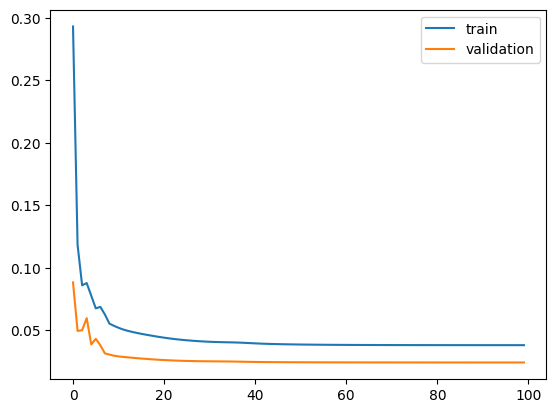

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [42]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)


385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


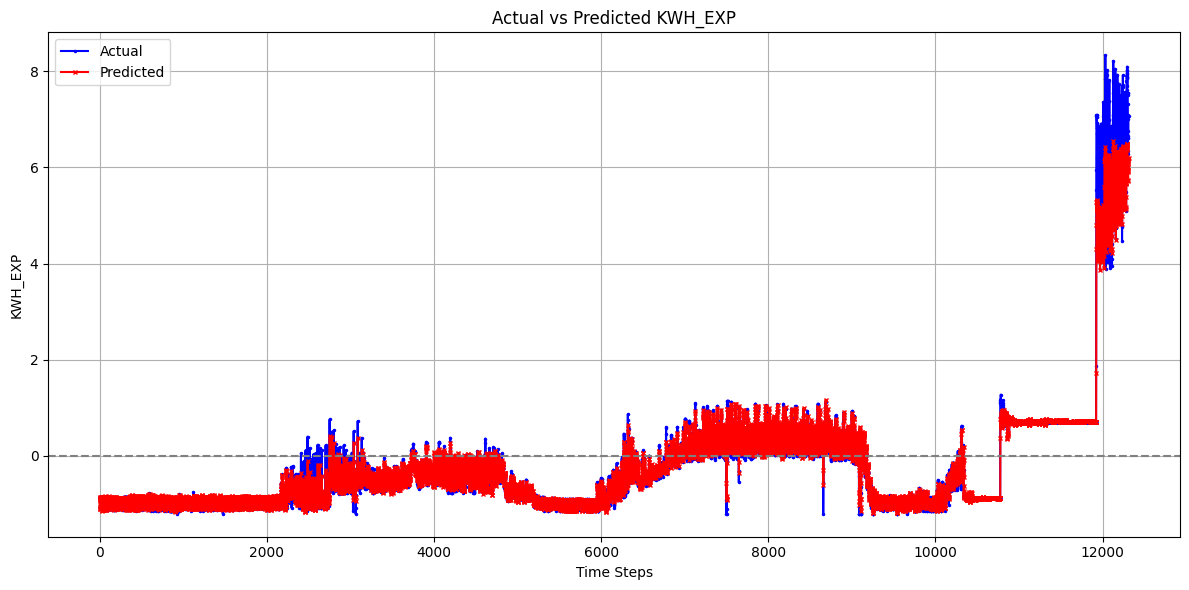

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Garis referensi
plt.title('Actual vs Predicted KWH_EXP')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [44]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.047689967163432684
MAE: 0.09137621161106116
R2: 0.9737226059046576
MAPE: 0.8198241685670624


# ATTENTION

In [45]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(units=128, return_sequences=True)(inputs)
x = AttentionLayer()(x)
x = LSTM(units=64, return_sequences=False)(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 96, 128)             │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_2 (AttentionLayer)   │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.4974 - val_loss: 0.1317 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2912 - val_loss: 0.1152 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2560 - val_loss: 0.1162 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2504 - val_loss: 0.1127 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2458 - val_loss: 0.1052 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2314 - val_loss: 0.0935 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2000 - val_loss: 0.0964 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2062 - val_loss: 0.0859 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1789 - val_loss: 0.0834 - learning_rate: 6.703

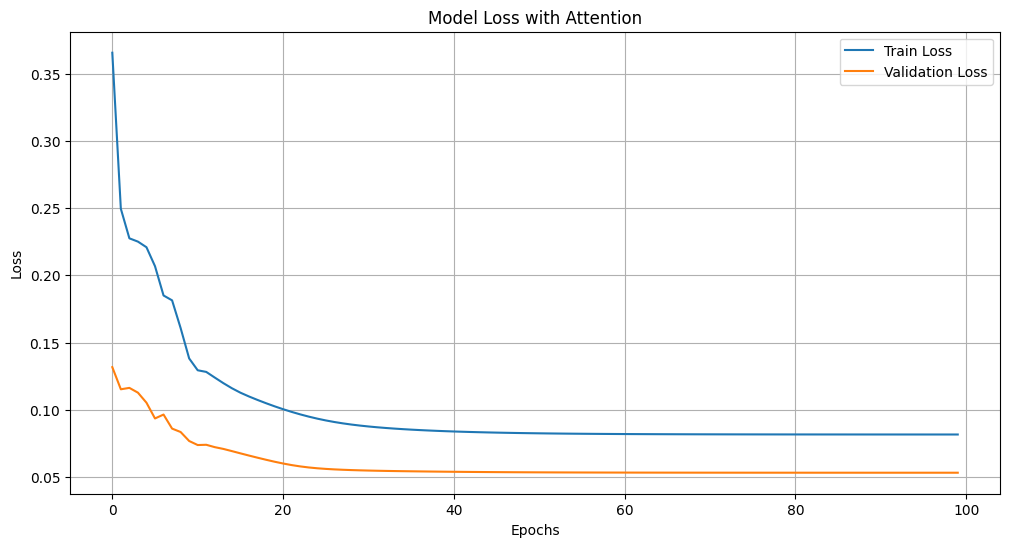

385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [46]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

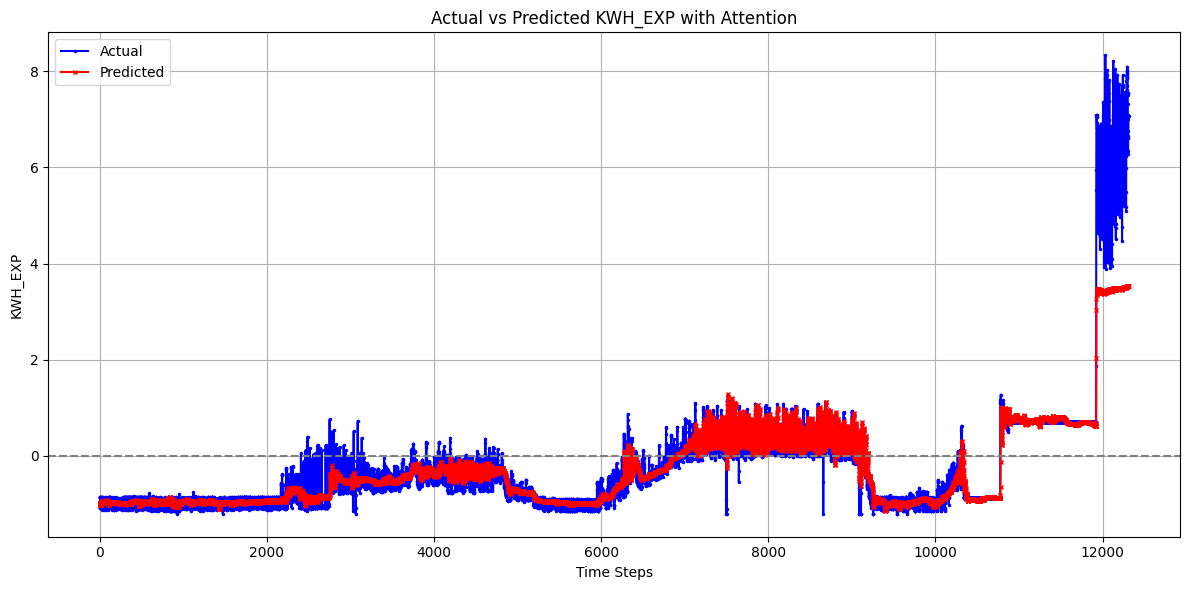

In [47]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [48]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.33434654659436097
MAE: 0.21495148108472537
R²: 0.8157734951008009
MAPE: 1.899959980164527


BILSTM ATTENTION

In [49]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)
x = AttentionLayer()(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 96, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 96, 256)             │         137,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_3 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301,697 (1.15 MB)

 Trainable params: 301,697 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.4672 - val_loss: 0.1737 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.2906 - val_loss: 0.1045 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.2581 - val_loss: 0.1010 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.2324 - val_loss: 0.0954 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.2154 - val_loss: 0.0959 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1601 - val_loss: 0.1110 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1800 - val_loss: 0.0711 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1308 - val_loss: 0.0509 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1093 - val_loss: 0.0521 - learning_rate: 6.703

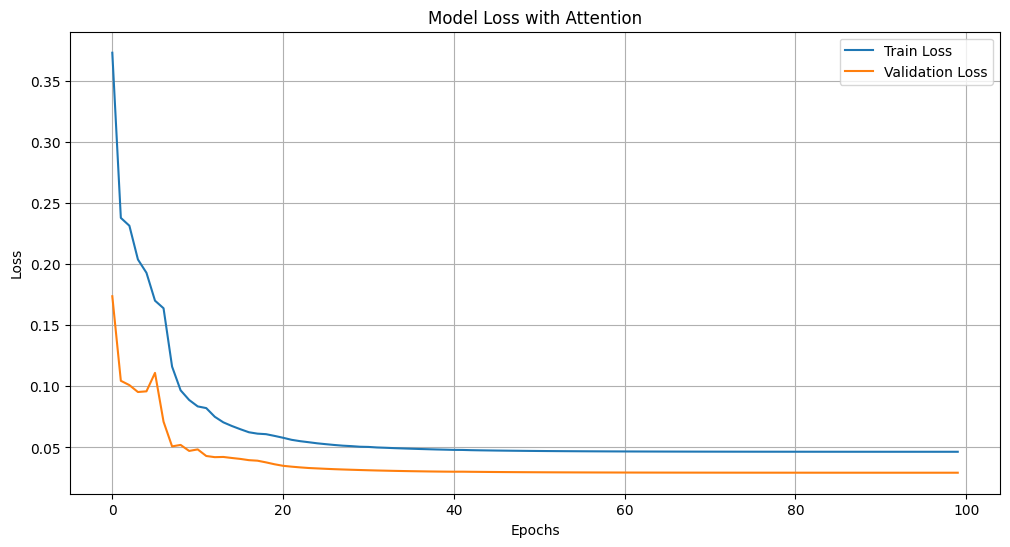

385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [50]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

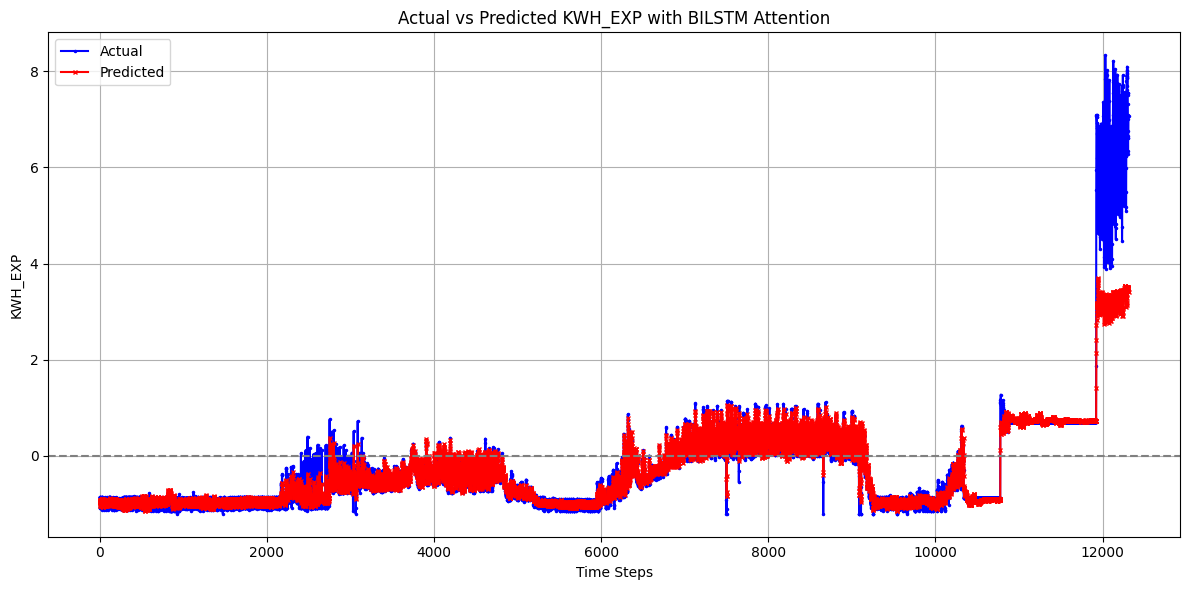

In [51]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with BILSTM Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [52]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.3673745623344814
MAE: 0.18326943228180514
R²: 0.7975749045499608
MAPE: 1.1736049939439637


# LSTM

In [53]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 96, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 96, 256)             │         137,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_3 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301,697 (1.15 MB)

 Trainable params: 301,697 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0900 - val_loss: 0.0704 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1037 - val_loss: 0.0569 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0961 - val_loss: 0.0417 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0775 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0706 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0644 - val_loss: 0.0316 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0657 - val_loss: 0.0397 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0670 - val_loss: 0.0356 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0682 - val_loss: 0.0292 - learning_rate: 6.703

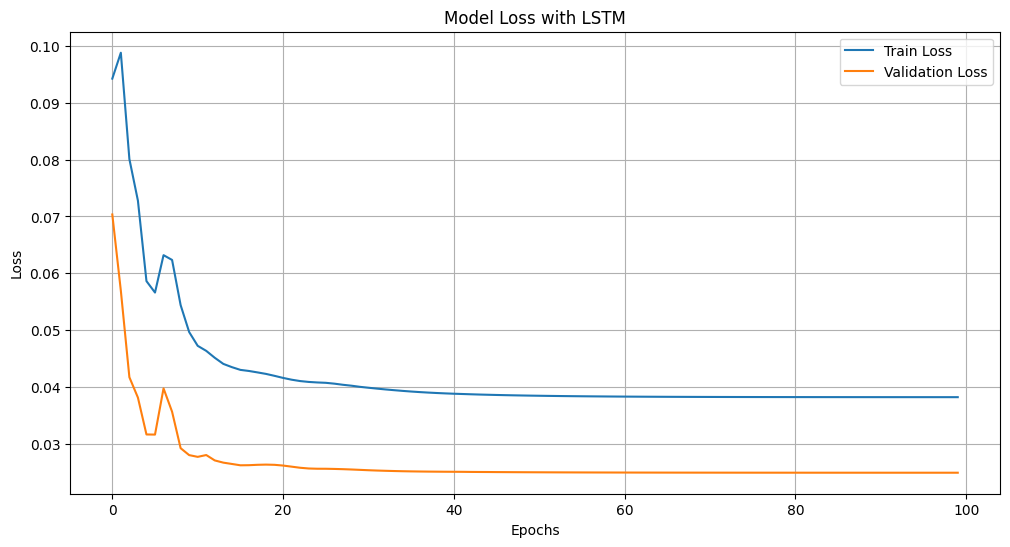

385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [54]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

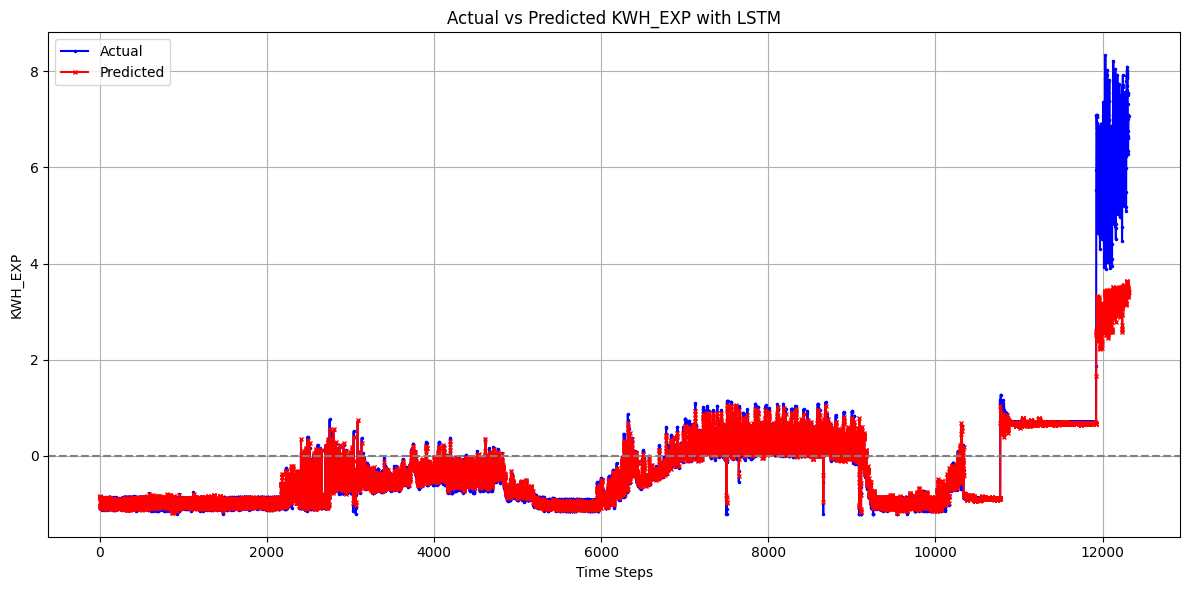

In [55]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [56]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.3737880408579607
MAE: 0.16648464444085798
R²: 0.7940410480030287
MAPE: 0.8019856353599167
